## Exploration of methodologies
Compilation of different techniques to charachterize manipulate time-series.

### Data
Fetch some time series from BRO and DINO to get to work.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scripts.utils_bro

In [3]:
GLD_ID_1 = "GLD000000054694" # BRO-ID
GLD_ID_2 = "GLD000000050281" # BRO-ID

In [4]:
bro_1_df = utils_bro.get_bro_data(GLD_ID_1)
bro_2_df = utils_bro.get_bro_data(GLD_ID_2)
dino_df = pd.read_csv("B31B0190_001_full.csv", skiprows=14, usecols=['Peildatum', 'Stand (cm t.o.v NAP)'])
bro_0_df = pd.read_csv("GLD000000057428_full.csv", skiprows=9, usecols=['tijdstip meting', 'waterstand'])

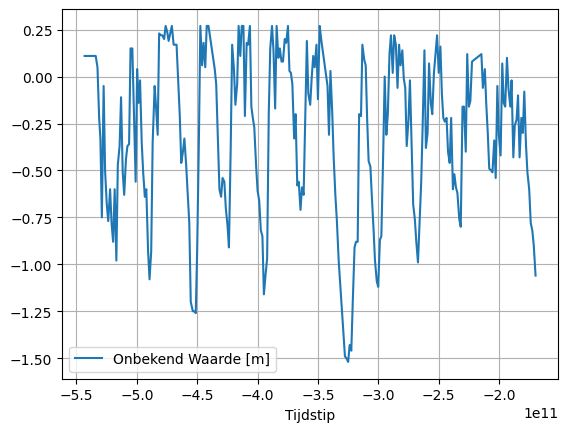

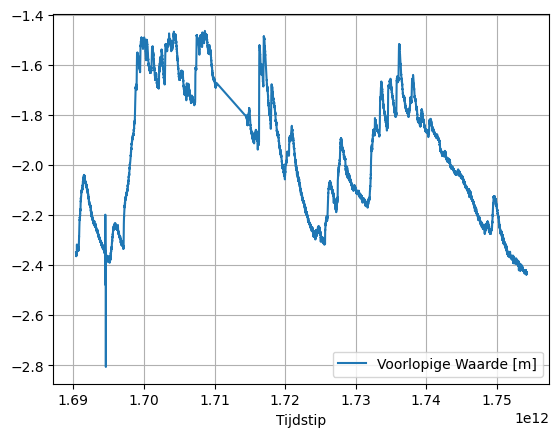

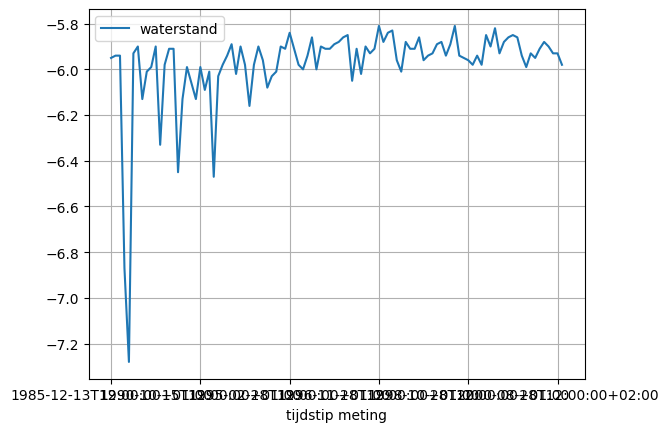

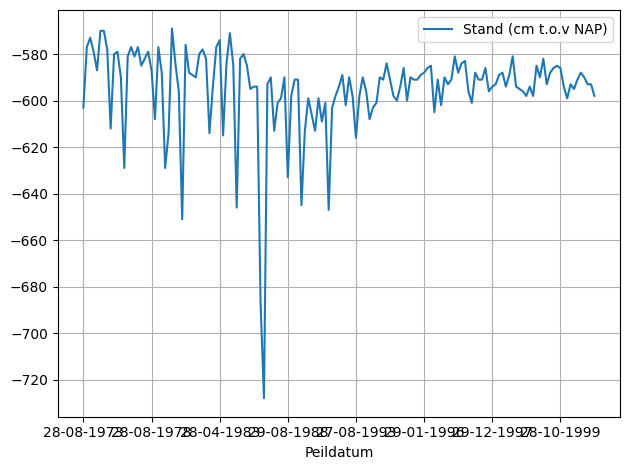

In [5]:
bro_1_df.plot(x='Tijdstip', y=bro_1_df.columns[1], kind='line', grid=True)
bro_2_df.plot(x='Tijdstip', y=bro_2_df.columns[1], kind='line', grid=True)
bro_0_df.plot(x='tijdstip meting', y='waterstand', kind='line', grid=True)
dino_df.plot(x='Peildatum', y='Stand (cm t.o.v NAP)', kind='line', grid=True)
plt.tight_layout()

In [6]:
# Normalization
s1 = bro_1_df[bro_1_df.columns[1]].values
s2 = bro_2_df[bro_2_df.columns[1]].values
s3 = dino_df['Stand (cm t.o.v NAP)'].values
s4 = bro_0_df['waterstand'].dropna().values
s1 = (s1 - np.mean(s1))/np.std(s1)
s2 = (s2 - np.mean(s2))/np.std(s2)
s3 = (s3 - np.mean(s3))/np.std(s3)
s4 = (s4 - np.mean(s4))/np.std(s4)
print(f"Mean bro_1: {np.mean(s1)}, std bro_1: {np.std(s1)}, length bro_1: {len(s1)}")
print(f"Mean bro_2: {np.mean(s2)}, std bro_2: {np.std(s2)}, length bro_2: {len(s2)}")
print(f"Mean dino: {np.mean(s3)}, std dino: {np.std(s3)}, length dino: {len(s3)}")
print(f"Mean bro_0: {np.mean(s4)}, std bro_0: {np.std(s4)}, length bro_0: {len(s4)}")

Mean bro_1: -1.3664283380001927e-17, std bro_1: 1.0, length bro_1: 260
Mean bro_2: 5.313430179366327e-16, std bro_2: 1.0, length bro_2: 16582
Mean dino: 1.5469597641134632e-15, std dino: 1.0, length dino: 151
Mean bro_0: -8.23969841158921e-15, std bro_0: 0.9999999999999998, length bro_0: 102


In [35]:
t1 = bro_1_df['Tijdstip'].values
t2 = bro_2_df['Tijdstip'].values
t3 = dino_df['Peildatum'].values
t4 = bro_0_df['tijdstip meting'].dropna().values

In [44]:
import re
def parse_date_to_unix(timestamps, default_tz='UTC'):
    """
    Convert ISO 8601 or date-only strings to Unix time (seconds since epoch).
    For date-only values, set time to midnight.
    
    Args:
        timestamps: list of strings (ISO or date-only)
        default_tz: timezone to assume if none provided, univ time is in UTC format
        dayfirst: interpret day-first for date-only formats like '28-08-1973' as given by BRO because we are in Europe.
    
    Returns:
        list of floats (Unix time in seconds)
    """
    _YFIRST = re.compile(r"^\d{4}[-/]\d{1,2}[-/]\d{1,2}")
    unix_times = []
    for ts in timestamps:
        if not isinstance(ts, str): 
            raise ValueError("Timestamps must be strings")
        ts = ts.strip()
        if not ts:
            unix_times.append(None)
            continue
        try:
            if _YFIRST.match(ts) or "T" in ts: # ISO & Y-first
                dt = pd.to_datetime(ts, utc=True)  
            else:  # Day-first branch
                dt = pd.to_datetime(ts, dayfirst=True)
            if dt.tzinfo is None:
                dt = dt.tz_localize(default_tz)
            unix_times.append(dt.timestamp())  # seconds since epoch
        except Exception:
            unix_times.append(None)
    return unix_times


In [56]:
times = {'s1': t1, 's2': t2, 's3': parse_date_to_unix(t3), 's4': parse_date_to_unix(t4)}
series = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}

## Methods

### Dynamics Time wrapping (DTW)
We calculate the distance directly on the time series.
The commutativity of the method and implementation was checked.

In [26]:
from tslearn.metrics import dtw

/home/luisa/micromamba/envs/ts/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [27]:
dist_1_2 = dtw(s1, s2)
dist_1_3 = dtw(s1, s3)
dist_2_3 = dtw(s2, s3)
dist_3_4 = dtw(s3, s4)
dist_1_1 = dtw(s1, s1)
dist_2_2 = dtw(s2, s2)
dist_3_3 = dtw(s3, s3)
print(f"DTW distance s1 - s2: {dist_1_2}")
print(f"DTW distance s1 - s3: {dist_1_3}")
print(f"DTW distance s2 - s3: {dist_2_3}")
print(f"DTW distance s3 - s4: {dist_3_4}")
# Sanity check:
print(f"DTW distance s1 - s1: {dist_1_1}")
print(f"DTW distance s2 - s2: {dist_2_2}")
print(f"DTW distance s3 - s3: {dist_3_3}")

/home/luisa/micromamba/envs/ts/lib/python3.12/site-packages/tslearn/metrics/dtw_variants.py:1766: SyntaxWarning: invalid escape sequence '\d'
  The Sakoe-Chiba radius corresponds to the parameter :math:`\delta` mentioned in [1]_,


KeyboardInterrupt: 

### Wavelets decomposition

In wavelets one decopose signals in different levels and amplitudes with regards to a specific (mother or predefined) wavelet. One stretch (scale) and shift (translate) a mother wavelet to capture similarities at different scales (frequency bands).
The wavelets supported by `pywt` can be explored:
`pywt.families(short=False)`

In [ ]:
import pywt
from itertools import combinations
from scipy.spatial.distance import euclidean

def decompose(x, wavelet='db4', level=None):
    if level is None:
        level = pywt.dwt_max_level(len(x), pywt.Wavelet(wavelet).dec_len)
    coeffs = pywt.wavedec(x, wavelet, level=level)
    # coeffs[0] = approximation at coarsest scale, coeffs[1:] = details (from coarse->fine)
    energies = [np.sum(c**2) for c in coeffs]
    return {'coeffs': coeffs, 'energies': np.array(energies), 'wavelet': wavelet, 'level': level}

def flatten_details(coeffs):
    # join detail arrays into single vector (useful for distance)
    details = coeffs[1:]  # skip approximation
    return np.concatenate([np.asarray(d).ravel() for d in details])


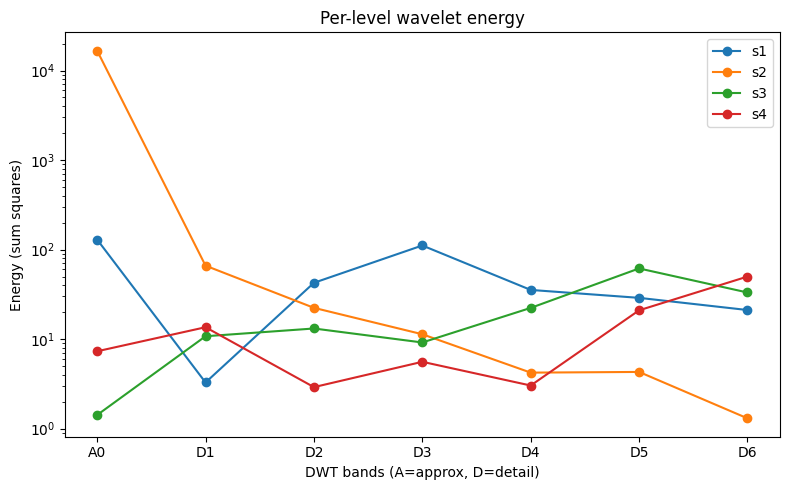

In [ ]:
results = {name: decompose(v, wavelet='haar', level=6) for name, v in series.items()}

# plot per-level energy (approx + details) for each series
plt.figure(figsize=(8,5))
# find max number of bands across series and build common x
max_bands = max(len(res['energies']) for res in results.values())
levels = range(max_bands)

# prepare padded energy arrays (pad with NaN so plotting keeps gaps)
for name, res in results.items():
    e = np.asarray(res['energies'])
    if len(e) < max_bands:
        e = np.pad(e, (0, max_bands - len(e)), constant_values=np.nan)
    plt.plot(levels, e, marker='o', label=name)

plt.xticks(levels, [f"A{0}" ] + [f"D{l}" for l in range(1, len(levels))])
plt.xlabel('DWT bands (A=approx, D=detail)')
plt.ylabel('Energy (sum squares)')
plt.yscale('log')
plt.title('Per-level wavelet energy')
plt.legend()
plt.tight_layout()

In [ ]:
results['s1']['energies']

array([209.31597908,  38.90606464, 121.68868394,  54.29081367,
        17.35739158,  17.50915392])

In [ ]:
print(results['s1']['energies'])
print(results['s1']['level'])

[209.31597908  38.90606464 121.68868394  54.29081367  17.35739158
  17.50915392]
5


Pairwise Euclidean distances on detail-coeff vectors:
s1 <-> s2: 19.1071
s1 <-> s3: 20.0100
s1 <-> s4: 18.4757
s2 <-> s3: 16.1046
s2 <-> s4: 14.4039
s3 <-> s4: 16.6276


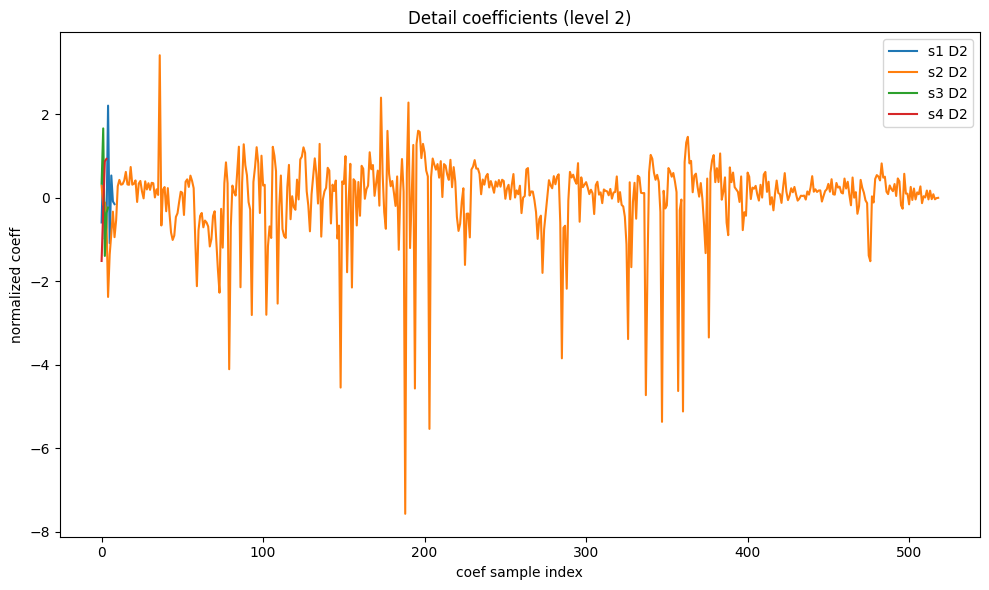

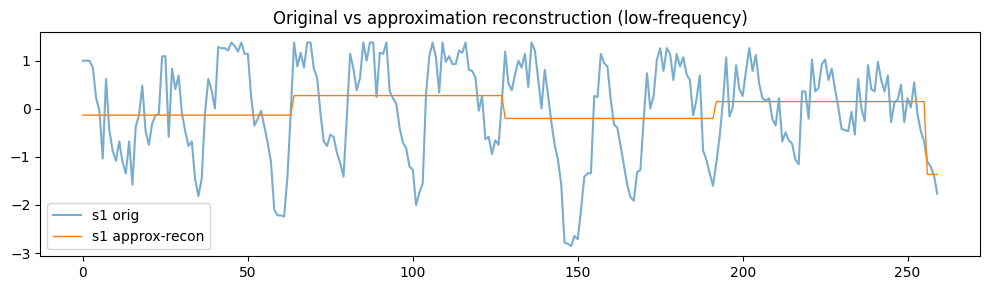

In [ ]:
# pairwise distances on flattened detail coefficients
flat = {name: flatten_details(res['coeffs']) for name, res in results.items()}
# make vectors same length by trunc/pad
maxlen = max(map(len, flat.values()))
for name, v in flat.items():
    if len(v) < maxlen:
        flat[name] = np.pad(v, (0, maxlen - len(v)), mode='constant')
    else:
        flat[name] = v[:maxlen]

print("Pairwise Euclidean distances on detail-coeff vectors:")
for a, b in combinations(flat.keys(), 2):
    print(f"{a} <-> {b}: {euclidean(flat[a], flat[b]):.4f}")

# visualize detail coefficients for a chosen level (e.g. detail index 2)
detail_level = 2  # 1 = finest detail in pywt.wavedec order (coeffs[1])
plt.figure(figsize=(10,6))
for name, res in results.items():
    coeffs = res['coeffs']
    if len(coeffs) > detail_level:
        d = coeffs[detail_level]
        # normalize for plotting
        d = (d - np.mean(d)) / (np.std(d) + 1e-12)
        plt.plot(np.arange(len(d)), d, label=f"{name} D{detail_level}")
plt.xlabel('coef sample index')
plt.ylabel('normalized coeff')
plt.title(f'Detail coefficients (level {detail_level})')
plt.legend()
plt.tight_layout()
plt.show()

# optional: reconstruct signal from approximation or selected detail bands
# Example: reconstruct using only approximation (low-frequency)
name = 's1'
coeffs = results[name]['coeffs']
approx_only = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
recon_approx = pywt.waverec(approx_only, results[name]['wavelet'])
plt.figure(figsize=(10,3))
plt.plot(series[name], label=f'{name} orig', alpha=0.6)
plt.plot(recon_approx[:len(series[name])], label=f'{name} approx-recon', lw=1)
plt.legend()
plt.title('Original vs approximation reconstruction (low-frequency)')
plt.tight_layout()
plt.show()
# ...existing code...

Top combos by mean Euclidean distance:
wavelet  level  mean_euc  min_euc  mean_cos
   haar      6  4.239573 2.694179  1.312665
   haar      5  3.945642 2.691823  1.321163
    db2      5  3.856982 1.633593  1.294892
   haar      4  3.599829 2.599011  1.319169
    db2      4  3.509749 1.631314  1.288163
   haar      3  3.176547 1.967688  1.305946
    db4      3  3.170772 2.083179  1.297975
bior3.3      3  3.145564 2.129048  1.296718
   sym4      3  3.117396 1.557936  1.274129
    db2      3  3.085674 1.629472  1.271105

Top combos by minimum pairwise distance:
wavelet  level  mean_euc  min_euc  mean_cos
   haar      6  4.239573 2.694179  1.312665
   haar      5  3.945642 2.691823  1.321163
   haar      4  3.599829 2.599011  1.319169
bior3.3      3  3.145564 2.129048  1.296718
    db4      3  3.170772 2.083179  1.297975
bior3.3      2  2.736919 1.995805  1.299379
   haar      3  3.176547 1.967688  1.305946
    db4      2  2.723104 1.822929  1.295872
   haar      2  2.675926 1.669372  1.25

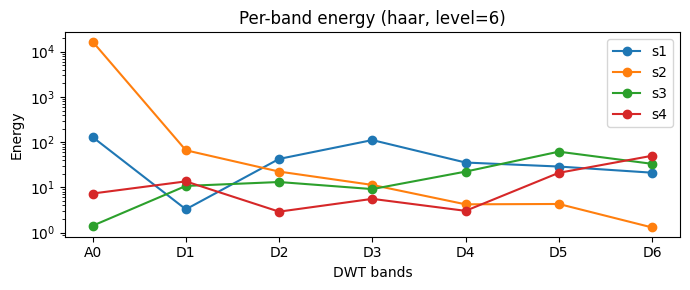

In [ ]:
from scipy.spatial.distance import pdist, squareform
# wavelet candidates to try
wavelets = ['haar','db2','db4','db8','sym4','coif3','bior3.3']
results_grid = []
names = list(series.keys())

for w in wavelets:
    # check max allowed level per series for this wavelet
    max_levels_per_series = []
    dec_len = pywt.Wavelet(w).dec_len
    for name in names:
        L = len(series[name])
        max_levels_per_series.append(pywt.dwt_max_level(L, dec_len))
    max_common_level = min(max_levels_per_series)
    if max_common_level < 1:
        continue
    for level in range(1, max_common_level+1):
        # build feature matrix: per-band energies (A0, D1..Dlevel) => length level+1
        feats = []
        valid = True
        for name in names:
            x = series[name]
            try:
                coeffs = pywt.wavedec(x, w, level=level)
            except Exception:
                valid = False
                break
            energies = np.array([np.sum(c**2) for c in coeffs])  # len = level+1
            feats.append(energies)
        if not valid:
            continue
        F = np.vstack(feats)  # shape (n_series, level+1)
        # optional: normalize features per-band (zero-mean / unit) to avoid scale bias
        Fz = (F - np.nanmean(F, axis=0)) / (np.nanstd(F, axis=0) + 1e-12)
        dists = pdist(Fz, metric='euclidean')
        mean_dist = np.mean(dists)
        min_dist = np.min(dists)
        # also compute pairwise cosine mean (optional)
        cos_mean = np.mean(pdist(Fz, metric='cosine'))
        results_grid.append({'wavelet': w, 'level': level,
                             'mean_euc': float(mean_dist), 'min_euc': float(min_dist),
                             'mean_cos': float(cos_mean)})

# collect and show top candidates by mean_euc and by min_euc
df_scores = pd.DataFrame(results_grid)
if df_scores.empty:
    print("No valid wavelet/level combos (series too short for chosen wavelets).")
else:
    df_scores = df_scores.sort_values(['mean_euc','min_euc'], ascending=False).reset_index(drop=True)
    print("Top combos by mean Euclidean distance:")
    print(df_scores.head(10).to_string(index=False))
    print("\nTop combos by minimum pairwise distance:")
    print(df_scores.sort_values('min_euc', ascending=False).head(10).to_string(index=False))

# Quick plot: show per-band energies for the best combo (first row)
if not df_scores.empty:
    best = df_scores.iloc[0]
    print(f"\nPlotting energies for best combo: {best['wavelet']} level={int(best['level'])}")
    w = best['wavelet']; level = int(best['level'])
    plt.figure(figsize=(7,3))
    max_bands = level+1
    for name in names:
        coeffs = pywt.wavedec(series[name], w, level=level)
        e = np.array([np.sum(c**2) for c in coeffs])
        if len(e) < max_bands:
            e = np.pad(e, (0, max_bands - len(e)), constant_values=np.nan)
        plt.plot(range(max_bands), e, marker='o', label=name)
    labels = ['A0'] + [f'D{l}' for l in range(1, max_bands)]
    plt.xticks(range(max_bands), labels)
    plt.yscale('log')
    plt.xlabel('DWT bands')
    plt.ylabel('Energy')
    plt.title(f'Per-band energy ({w}, level={level})')
    plt.legend()
    plt.tight_layout()
    plt.show()

## FFT Spectra
It might be interesting to look at how the spectra of the time series looks like.
Spectra might be biased and not adequeate in this case mainly because:
- Time series shave different sampling rates (ranging from mintues to several days)
- Lenght of sequences can be drastically different.

In this case the frequency, would not be comparable, it might be more sueful to compare the power spectral density (PSD).

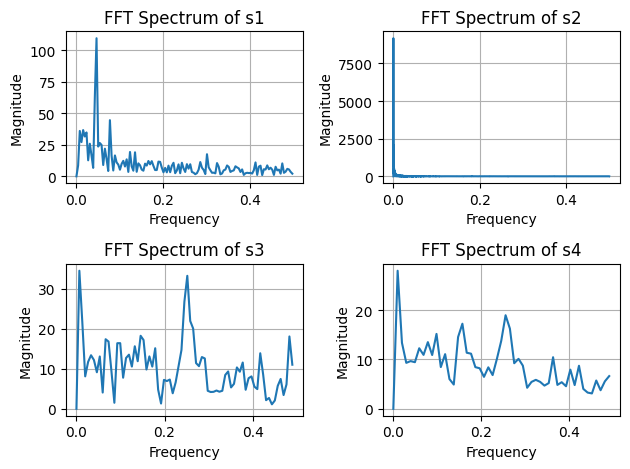

In [57]:
for i, (name, data) in enumerate(series.items()):
    # Compute FFT
    fft_result = np.fft.fft(data)
    magnitude = np.abs(fft_result)
    # Frequency axis (assuming sampling rate of 1)
    freq = np.fft.fftfreq(len(data), d=1)
    
    # Plot only positive frequencies up to Nyquist
    pos_freq = freq[:len(freq)//2]
    pos_magnitude = magnitude[:len(magnitude)//2]
    
    plt.subplot(2, 2, i+1)
    plt.plot(pos_freq, pos_magnitude)
    plt.title(f'FFT Spectrum of {name}')
    plt.xlabel('Frequency'); plt.ylabel('Magnitude')
    plt.grid(True)

plt.tight_layout()
plt.show()

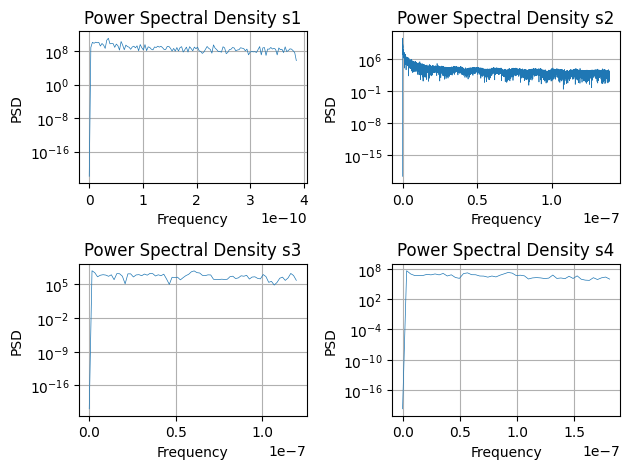

In [ ]:
psd = {}
# Power spectral density
for i, (name, x) in enumerate(series.items()):
    N = len(x)
    #w = np.hanning(N)
    t = times[name]
    fs = 1.0 / np.median(np.diff(t)) # replace with real query to the time axis
    #x = x - np.mean(x)
    X = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    #U = (1.0 / N) * np.sum(w**2)      # window power normalization
    Pxx = (1.0 / (fs * N )) * (np.abs(X) ** 2)
    
    # One-sided correction: double all bins except DC and Nyquist
    if N % 2 == 0:
        Pxx[1:-1] *= 2.0
    else:
        Pxx[1:] *= 2.0
    psd[name] = [freqs, Pxx]

    plt.subplot(2, 2, i+1)
    plt.semilogy(freqs, Pxx, lw=0.5)
    plt.title(f'Power Spectral Density {name}')
    plt.xlabel('Frequency'); plt.ylabel('PSD')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [83]:
def psd_fingerprint(freqs, Pxx, n_bands=24, fmin=None, fmax=None,
                    log_scale=True, norm='l2', eps=1e-12):
    """
    Compress PSD into n_bands of integrated power (a fingerprint vector).
    freqs: 1D array of frequencies (>0)
    Pxx:   1D PSD (non-negative)
    n_bands: number of bands to integrate
    fmin/fmax: common range for comparability; if None, uses data range
    log_scale: log-spaced bands (good for wide ranges); else linear
    norm: 'l2' | 'sum' | None  (how to normalize the fingerprint)
    """
    f = np.asarray(freqs); S = np.asarray(Pxx)
    mask = np.isfinite(f) & np.isfinite(S) & (f > 0) & (S >= 0)
    f, S = f[mask], S[mask]
    order = np.argsort(f); f, S = f[order], S[order]

    fmin = max(f.min(), fmin) if fmin is not None else f.min()
    fmax = min(f.max(), fmax) if fmax is not None else f.max()
    if not np.isfinite(fmin) or not np.isfinite(fmax) or fmax <= fmin:
        raise ValueError("Invalid fmin/fmax after masking.")

    edges = (np.logspace(np.log10(fmin), np.log10(fmax), n_bands+1)
             if log_scale else np.linspace(fmin, fmax, n_bands+1))

    band_power = np.zeros(n_bands, dtype=float)
    for i in range(n_bands):
        a, b = edges[i], edges[i+1]
        m = (f >= a) & (f <= b)
        if m.sum() >= 2:
            band_power[i] = np.trapezoid(S[m], f[m])  # integrate PSD over the band
        elif m.sum() == 1:
            # single point: approximate power as PSD * band width
            band_power[i] = S[m][0] * (b - a)
        # else remains 0 if no samples fall into the band

    # Normalize fingerprint
    if norm == 'sum':
        s = band_power.sum() + eps
        band_power = band_power / s
    elif norm == 'l2':
        n = np.linalg.norm(band_power) + eps
        band_power = band_power / n

    return band_power, edges

In [87]:
# Similarity scores
def cosine_similarity(f1, f2, eps=1e-12):
    return float(np.dot(f1, f2) / (np.linalg.norm(f1)*np.linalg.norm(f2) + eps))

def js_similarity(f1, f2, eps=1e-12):
    # Jensen–Shannon similarity in [0,1]; fingerprints treated as distributions
    p = f1 / (f1.sum() + eps); q = f2 / (f2.sum() + eps)
    m = 0.5*(p+q)
    def kl(a,b): return np.sum(a*np.log((a+eps)/(b+eps)))
    jsd = 0.5*kl(p,m) + 0.5*kl(q,m)
    return float(1.0 - np.sqrt(jsd / np.log(2)))  # 1=identical, 0=dissimilar


In [ ]:
# Pick a **common** frequency range so fingerprints are comparable:
mins, maxs = [], []
for name, (freqs, Pxx) in psd.items():
    f = np.asarray(freqs, float)
    m = np.isfinite(f) & (f > 0)      # use (f >= 0) if you want to include DC
    if m.sum() >= 2:                  # need at least two valid points
        mins.append(f[m].min())
        maxs.append(f[m].max())

if not mins or not maxs:
    raise ValueError("No valid positive frequencies found in any series.")

fmin_common = float(np.max(mins))     # highest of the per-series mins
fmax_common = float(np.min(maxs))     # lowest of the per-series maxs
print(fmin_common, fmax_common)
if fmax_common <= fmin_common:
    raise ValueError("No overlapping frequency range across series.")


3.5459785766158317e-09 3.8580246913580243e-10


ValueError: No overlapping frequency range across series.

In [ ]:
fprints = []
for name, (freqs, Pxx) in psd.items():
    fp, _ = psd_fingerprint(freqs, Pxx, n_bands=20,
                            fmin=fmin_common, fmax=fmax_common,
                            log_scale=True, norm='l2')
    fprints.append(fp)

In [105]:
fprints

[array([0.3669794 , 0.        , 0.2904493 , 0.07114384, 0.11963952,
        0.14309159, 0.12741052, 0.09734228, 0.12314315, 0.51022448,
        0.1108053 , 0.1036536 , 0.32189341, 0.12167644, 0.41248725,
        0.05725483, 0.05574585, 0.09930186, 0.18935559, 0.27608438]),
 array([0.3669794 , 0.        , 0.2904493 , 0.07114384, 0.11963952,
        0.14309159, 0.12741052, 0.09734228, 0.12314315, 0.51022448,
        0.1108053 , 0.1036536 , 0.32189341, 0.12167644, 0.41248725,
        0.05725483, 0.05574585, 0.09930186, 0.18935559, 0.27608438]),
 array([0.3669794 , 0.        , 0.2904493 , 0.07114384, 0.11963952,
        0.14309159, 0.12741052, 0.09734228, 0.12314315, 0.51022448,
        0.1108053 , 0.1036536 , 0.32189341, 0.12167644, 0.41248725,
        0.05725483, 0.05574585, 0.09930186, 0.18935559, 0.27608438]),
 array([0.3669794 , 0.        , 0.2904493 , 0.07114384, 0.11963952,
        0.14309159, 0.12741052, 0.09734228, 0.12314315, 0.51022448,
        0.1108053 , 0.1036536 , 0.32189341

In [106]:
psd_dist_1_2 = cosine_similarity(fprints[0], fprints[1])
psd_dist_1_3 = cosine_similarity(fprints[0], fprints[2])
psd_dist_2_3 = cosine_similarity(fprints[1], fprints[2])
psd_dist_3_4 = cosine_similarity(fprints[2], fprints[3])
psd_dist_1_1 = cosine_similarity(fprints[0], fprints[0])
psd_dist_2_2 = cosine_similarity(fprints[1], fprints[1])

print(f"cosine similarity PSD s1 - s2: {psd_dist_1_2}")
print(f"cosine similarity PSD s1 - s3: {psd_dist_1_3}")
print(f"cosine similarity PSD s2 - s3: {psd_dist_2_3}")
print(f"cosine similarity PSD s3 - s4: {psd_dist_3_4}")
# Sanity check:
print(f"cosine similarity PSD s1 - s1: {psd_dist_1_1}")
print(f"cosine similarity PSD s2 - s2: {psd_dist_2_2}")


cosine similarity PSD s1 - s2: 0.999999999999
cosine similarity PSD s1 - s3: 0.999999999999
cosine similarity PSD s2 - s3: 0.999999999999
cosine similarity PSD s3 - s4: 0.999999999999
cosine similarity PSD s1 - s1: 0.999999999999
cosine similarity PSD s2 - s2: 0.999999999999


In [107]:
psd_js_sim_1_2 = js_similarity(fprints[0], fprints[1])
psd_js_sim_1_3 = js_similarity(fprints[0], fprints[2])
psd_js_sim_2_3 = js_similarity(fprints[1], fprints[2])
psd_js_sim_3_4 = js_similarity(fprints[2], fprints[3])
psd_js_sim_1_1 = js_similarity(fprints[0], fprints[0])
psd_js_sim_2_2 = js_similarity(fprints[1], fprints[1])

print(f"js similarity PSD s1 - s2: {psd_js_sim_1_2}")
print(f"js similarity PSD s1 - s3: {psd_js_sim_1_3}")
print(f"js similarity PSD s2 - s3: {psd_js_sim_2_3}")
print(f"js similarity PSD s3 - s4: {psd_js_sim_3_4}")
# Sanity check:
print(f"js similarity PSD s1 - s1: {psd_js_sim_1_1}")
print(f"js similarity PSD s2 - s2: {psd_js_sim_2_2}")

js similarity PSD s1 - s2: 1.0
js similarity PSD s1 - s3: 1.0
js similarity PSD s2 - s3: 1.0
js similarity PSD s3 - s4: 1.0
js similarity PSD s1 - s1: 1.0
js similarity PSD s2 - s2: 1.0


## TS Encoder + distance in latent space

#### granite-TSFM (IBM)
Following this [notebook](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/tspulse_search_simple_example.ipynb), we are going to:
1. Load a model (already trained)
2. Convert the time-series to windows of size 512 (because model is defined with this input size)
3. Calculate the embeddings of our data (windows of time series)
4. We can calculate the cosine distance between the embeddings of the different windows.

In [ ]:
import torch
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import set_seed

from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.models.tspulse.utils.helpers import get_embeddings
from tsfm_public.toolkit.dataset import ClassificationDFDataset
from tsfm_public.toolkit.util import convert_tsfile_to_dataframe

In [ ]:
model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    revision="tspulse-hybrid-dualhead-512-p8-r1",
    num_input_channels=1,
    mask_type="user",
)
model.eval()

TSPulseForReconstruction(
  (loss): MSELoss()
  (backbone): TSPulseModel(
    (encoder_block): TSPulseBlock(
      (mixers): ModuleList(
        (0-7): 8 x TSPulseLayer(
          (patch_mixer): PatchMixerBlock(
            (norm): TSPulseNormLayer(
              (norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            )
            (mlp): TSPulseMLP(
              (fc1): Linear(in_features=138, out_features=276, bias=True)
              (dropout1): Dropout(p=0.2, inplace=False)
              (fc2): Linear(in_features=276, out_features=138, bias=True)
              (dropout2): Dropout(p=0.2, inplace=False)
            )
            (gating_block): TSPulseGatedAttention(
              (attn_layer): Linear(in_features=138, out_features=138, bias=True)
              (attn_activation_layer): Softmax(dim=-1)
            )
          )
          (feature_mixer): FeatureMixerBlock(
            (norm): TSPulseNormLayer(
              (norm): LayerNorm((24,), eps=1e-05, elementwi

In [ ]:
s1_t = torch.tensor(s1, dtype=torch.float)

In [ ]:
win = 512 # context, not sure yet if this is fixed for the model trained or if we can configure it.
series = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}
mini_series = []

for name, arr in series.items():
    print(f"len({name}): {len(arr)}")
    x = np.asarray(arr, dtype=float)
    for i in range(0, len(x) - win + 1, win):
        w = x[i:i+win]
        if len(w) == win:
            mini_series.append(torch.tensor(w, dtype=torch.float32).unsqueeze(1))  # shape (win, 1)

X = torch.stack(mini_series)  # shape (n, win, 1)
print('Shape of X:', X.shape)

len(s1): 260
len(s2): 16582
len(s3): 151
len(s4): 102
Shape of X: torch.Size([32, 512, 1])


Because of the small size of out time-series, we are only considering the second one `s2` that is long enough to fit 32 windows of size 512.

In [42]:
with torch.no_grad():
    embs = get_embeddings(model, X, mode="register")

In [44]:
embs.shape

torch.Size([32, 1, 240])

In [47]:
embs[1]

tensor([[-1.8333e+00,  3.3323e-01,  2.6283e-01,  1.5544e-01,  9.9927e-02,
          1.3064e-01, -2.2451e-01,  9.2354e-01,  2.5143e-01,  3.4739e+00,
         -1.0246e-01,  8.6034e-01,  2.3296e-01,  7.8631e-02, -5.6750e-01,
          5.7496e-02,  1.1771e-01, -4.1897e-01, -2.8471e-01, -1.6980e+00,
         -2.7091e-01, -3.2785e-01,  5.0184e-01, -7.1601e-02, -2.7772e+00,
         -8.6707e-01, -4.9518e-01,  4.1757e-01, -7.9202e-01, -1.3412e-01,
          7.0351e-01,  1.2626e+00,  4.6116e-01,  4.4500e+00,  1.2285e+00,
         -6.8558e-01,  6.5150e-01, -2.7760e-01,  3.1618e-01,  7.2404e-01,
          4.2285e-01, -4.6813e-01, -4.0321e-01, -2.2852e-01, -2.5401e-01,
         -3.7013e+00,  6.3660e-01, -6.6579e-02, -1.1083e+00,  1.8979e-01,
          3.2063e-01,  2.8755e-02, -1.0778e-01,  1.4083e+00,  2.3328e-02,
          6.0665e-01, -2.5254e-02,  3.6399e+00,  6.7730e-01, -4.3390e-02,
         -3.9218e-03, -2.0383e-01,  4.7037e-01,  6.3482e-01,  1.2548e-01,
          8.2347e-03, -7.7462e-02,  1.

In [53]:
import torch.nn.functional as F
# embs: shape (32, 1, 240)
# Calculate cosine distance between the first 3 embeddings
for i in range(10):
    for j in range(i+1, 30):
        v1 = embs[i, 0]  # shape (240,)
        v2 = embs[j, 0]  # shape (240,)
        cos_sim = F.cosine_similarity(v1, v2, dim=0).item()
        cos_dist = 1 - cos_sim
        print(f"Cosine distance between embedding {i} and {j}: {cos_dist:.4f}")

Cosine distance between embedding 0 and 1: 0.0172
Cosine distance between embedding 0 and 2: 0.0272
Cosine distance between embedding 0 and 3: 0.0117
Cosine distance between embedding 0 and 4: 0.0108
Cosine distance between embedding 0 and 5: 0.0262
Cosine distance between embedding 0 and 6: 0.0720
Cosine distance between embedding 0 and 7: 0.0274
Cosine distance between embedding 0 and 8: 0.0447
Cosine distance between embedding 0 and 9: 0.0254
Cosine distance between embedding 0 and 10: 0.0237
Cosine distance between embedding 0 and 11: 0.0246
Cosine distance between embedding 0 and 12: 0.0156
Cosine distance between embedding 0 and 13: 0.0083
Cosine distance between embedding 0 and 14: 0.0047
Cosine distance between embedding 0 and 15: 0.0145
Cosine distance between embedding 0 and 16: 0.0852
Cosine distance between embedding 0 and 17: 0.0766
Cosine distance between embedding 0 and 18: 0.0121
Cosine distance between embedding 0 and 19: 0.0214
Cosine distance between embedding 0 and 